In [ ]:
!pip install ussa1976

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
import sympy as smp
import scipy.optimize as opt
import ussa1976 as usa
from dataclasses import dataclass
from functools import partial
from scipy.optimize import differential_evolution
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

In [ ]:
# 1D trajectory

#
# 1. ENGINE / VEHICLE DATA  (boosters + core, sea-level thrust)
#
kN = 1_000
g0 = 9.81                                  # m s-2
P0 = 101325.0                               # Pa
R_E  = 6_371_000.0          # m, mean Earth radius
μ_E  = g0 * R_E**2

#throttle_knots  = np.array([0,  10,  45, 130, 170, 187])   # s
#throttle_values = np.array([0.7, 1.0, 0.7, 0.92, 0.40, 0.0]) # –

#booster_knots  = np.array([0, 10, 45, 120, 154])   # s
#booster_values = np.array([1.0,1.0,0.9, 1.0, 0.0]) # –

n_booster = 2 #
n_engines_booster = 9
Thrust_booster_SL = 845 # sea level
Thrust_booster_Vac = 914
A_MERLIN_F9   = 0.90         # m2 per booster/core engine

BOOSTER = dict(
    T_SL       = n_booster * n_engines_booster * Thrust_booster_SL * kN, # N   (18 SRMs @ 845 kN each)
    T_Vac       = n_booster * n_engines_booster * Thrust_booster_Vac * kN, # N   (18 SRMs @ 845 kN each)
    Isp_SL     = 282, # s
    Isp_Vac     = 311, # s
    burn    = 154, # s
    m_prop  = 410_900 * n_booster, # kg  (two boosters)
    m_dry   = 22_200 * n_booster, # kg
    A_e = n_booster * n_engines_booster * A_MERLIN_F9
)

n_engines_core = 9
Thrust_core_SL = 845 # sea level
Thrust_core_Vac = 914

CORE = dict(
    T_SL       = n_engines_core * Thrust_core_SL * kN, # N 9 Merlin engines
    T_Vac       = n_engines_core * Thrust_core_Vac * kN, # N 9 Merlin engines
    Isp_SL     = 282, # s
    Isp_Vac     = 311, # s Second stage engine has larger expansion ratio
    burn    = 187, # s
    m_prop  = 410_900, # kg
    m_dry   = 22_200, # kg
    A_e = n_engines_core * A_MERLIN_F9
)

A_MERLIN_VAC  = 4.9

SECOND = dict(
    m_prop = 111_500,     # kg  (Merlin-Vac prop load; rough Falcon-9 upper)
    m_dry  =  4_000,      # kg  (dry hardware)
    T_vac  = 981 * kN,    # not used yet, but nice to store
    Isp_vac= 348,         #  –
    burn   = 397          #  –
)

# Second stage throttling doesn't matter for this problem!
second_knots   = np.array([0,   40, 330, SECOND['burn']])   # s since ignition
second_values  = np.array([1.0, 0.9, 0.4, 0.0])

PAYLOAD = 26_700

# Liftoff_mass = CORE['m_prop'] + CORE['m_dry'] + BOOSTER['m_prop'] + BOOSTER['m_dry'] + PAYLOAD

# Optimization params
N_SEG   = 4                         # segments for each stage (change anytime)
t_nodes = np.linspace(0, BOOSTER['burn'], N_SEG+1)   # 0-to-burn, inclusive
Q_MAX   = 45e3                      # Pa  (dynamic-pressure limit)
BIG_PEN = 1e9                       # penalty for infeasible runs
DELTA_V_TARGET = 2000.0       # m/s
DV_TOL         = 10.0         # accept ±10 m/s


def make_throttle_fn(schedule):
    def _throttle(t):
        idx = np.searchsorted(t_nodes, t, side='right') - 1
        # clamp idx to last segment (after CORE['burn'])
        idx = min(idx, len(schedule)-1)
        return schedule[idx]
    return _throttle


T_delay = 0.2 # 20% delay between stages
T_IGN = (1 + T_delay) * CORE['burn']
T_END = T_IGN + SECOND['burn']

#
# 2. Helpers
#

Z     = np.arange(0.0, 400_001.0, 100.0) # 0-400 km, 100 m
atm   = usa.compute(z=Z, variables=["rho", "p"])  # get density & pressure

def pressure_ussa(h):
    return np.interp(h, atm.z.values, atm.p.values)   # Pa

def density_ussa(h):
    return np.interp(h, atm.z.values, atm.rho.values)

def thrust_interp(stage, p):
    return stage['T_Vac'] - (stage['T_Vac'] - stage['T_SL']) * (p / P0)

def isp_interp(stage, p):
    return stage['Isp_Vac'] - (stage['Isp_Vac'] - stage['Isp_SL']) * (p / P0)

def throttle_second(t):
    if t < T_IGN: # engine not lit yet
        return 0.0
    return np.interp(t - T_IGN, second_knots, second_values)

def gravity(h):
    return μ_E / (R_E + h)**2

def decode(vec):
    core_sched   = vec[:N_SEG]
    boost_sched  = vec[N_SEG:]
    return core_sched, boost_sched


def event_q_limit(t, S, *args):
    h, v = S[0], S[1]

    rho = density_ussa(h)
    q   = 0.5 * rho * v**2          # Pa

    return q - Q_MAX                # crosses zero when q == Q_MAX

event_q_limit.terminal  = True      # halt the integrator
event_q_limit.direction = 1         # only upward crossings (increasing q)



d_core = 3.66
h_core = 70
#A_core = surface_area(d_core,h_core)

d_booster = 3.66
h_booster = 41.2
#A_booster = surface_area(d_booster,h_booster)

h_core_2 = h_core - h_booster

Cd     = 0.3

# 4. ODE SYSTEM  (dimensional altitude x [m] & velocity v [m s-1])

S0 = [0.0, 0.0, BOOSTER['m_prop'], CORE['m_prop'], SECOND['m_prop']]

def derivatives(t, S, thr_core, thr_boost):
    x, v, m_prop_b, m_prop_c, m_prop_s = S

    p_amb = pressure_ussa(x)
    rho   = density_ussa(x)
    g = gravity(x)

    #booster_attach = m_prop_b > 0.05 * BOOSTER['m_prop']
    booster_attach = t <= BOOSTER['burn']
    #stage_one_attach = m_prop_c > 0.05 * CORE['m_prop']
    stage_one_attach = t <= CORE['burn']

#Booster
    if booster_attach and m_prop_b > 0:
        throttle_b = thr_boost(t)
        T_b   = throttle_b * thrust_interp(BOOSTER, p_amb)
        Isp_b = isp_interp(BOOSTER, p_amb)
        mdot_b = T_b / (Isp_b * g0)
        dmp_b_dt = -mdot_b

    else:                               # detached -> no thrust, no mass flow
        T_b, dmp_b_dt = 0.0, 0.0

# Core
#    if m_prop_c > 0 and t <= CORE['burn']:
    if stage_one_attach and m_prop_c > 0:
        throttle = thr_core(t)
        T_c = throttle * thrust_interp(CORE, p_amb)
        Isp_c = isp_interp(CORE, p_amb)
        mdot_c = T_c / (Isp_c * g0)
        dmp_c_dt = -mdot_c
    else:
        T_c, dmp_c_dt = 0.0, 0.0


    if (t >= T_IGN) and (m_prop_s > 0):
      throttle_s  = throttle_second(t)
      T_s         = throttle_s * SECOND['T_vac']
      mdot_s      = T_s / (SECOND['Isp_vac'] * g0)
      dmp_s_dt    = -mdot_s
    else:
      T_s, dmp_s_dt = 0.0, 0.0

    # totals
    thrust = T_b + T_c + T_s

    if booster_attach:
        booster_mass = BOOSTER['m_dry'] + m_prop_b   # still bolted on
    else:
        booster_mass = 0.0                           # already dropped

    if stage_one_attach:
        first_stage_mass = CORE['m_dry'] + m_prop_c   # still bolted on
    else:
        first_stage_mass = 0.0                           # already dropped

    second_stage_mass = SECOND['m_dry'] + m_prop_s

    mass = booster_mass + first_stage_mass + second_stage_mass + PAYLOAD

    A_eff  = (np.pi * d_core ** 2/4) + (2 * np.pi * d_booster ** 2/4 if booster_attach else 0.0)  # ref areas
    drag   = 0.5*rho*Cd*A_eff*v*abs(v)

    dv_dt, dx_dt = (thrust-drag)/mass - g, v
    return [dx_dt, dv_dt, dmp_b_dt, dmp_c_dt, dmp_s_dt]

#
# 5. Objective
#

def objective(vec):
    core_sched, boost_sched = decode(vec)

    thr_core  = make_throttle_fn(core_sched)
    thr_boost = make_throttle_fn(boost_sched)

    # Closure with the two throttle functions baked in
    deriv = partial(derivatives, thr_core=thr_core, thr_boost=thr_boost)

    sol = solve_ivp(deriv,
                    t_span=[0, CORE['burn']],      # first stage only
                    y0     = S0,
                    max_step = 6,
                    events = (event_q_limit),
                    dense_output = False)

    # did we reach dV
    v_cut   = sol.y[1, -1]              # last velocity entry
    dv_err  = abs(v_cut - DELTA_V_TARGET)
    if dv_err > DV_TOL:
        return BIG_PEN + 1e7*dv_err     # big penalty if out of spec

    # dynamic-pressure check
    if len(sol.t_events[0]):      # index 0
        return BIG_PEN + 1.0

    # compute propellant USED until the cut
    m_used_boost = BOOSTER['m_prop'] - sol.y[2, -1]
    m_used_core  = CORE['m_prop']    - sol.y[3, -1]
    prop_used    = m_used_boost + m_used_core

    return prop_used      # minimize this!


def run_optimization():
  bounds = [(0.40, 1.0)] * (2 * N_SEG)         # 0.40 – 1.00 for every segment
  result = differential_evolution(objective,
                                  bounds,
                                  maxiter=15, # can mess around with this param
                                  popsize=5, # can mess around with this param
                                  workers=-1,
                                  updating = "deferred",
                                  polish=True)

  best_core, best_boost = decode(result.x)
  print(f"Prop. used first stage  : {result.fun:,.0f} kg")
  print("Core throttle schedule :", np.round(best_core, 3))
  print("Booster throttle schedule:", np.round(best_boost, 3))
  return best_core, best_boost

if __name__ == "__main__":
    run_optimization()


Prop. used first stage  : 928,089 kg
Core throttle schedule : [0.705 0.567 0.817 0.999]
Booster throttle schedule: [0.579 0.899 0.459 0.51 ]


Prop. used first stage  : 947,190 kg
Core throttle schedule : [0.999 0.988 0.546 0.75 ]
Booster throttle schedule: [0.895 0.493 0.511 0.677]


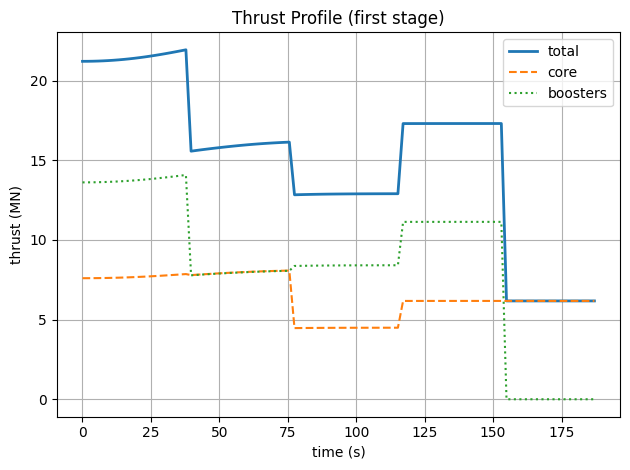

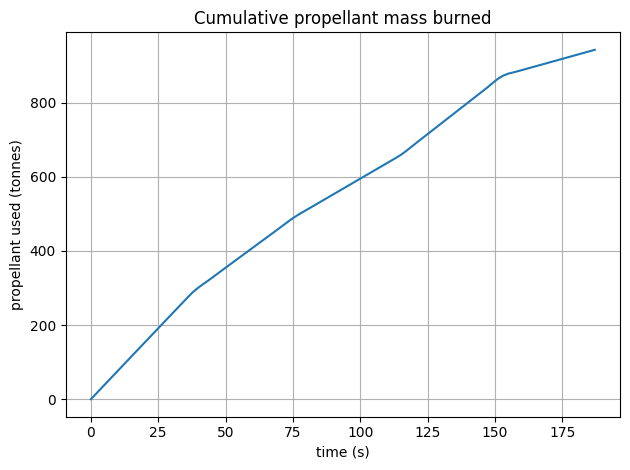

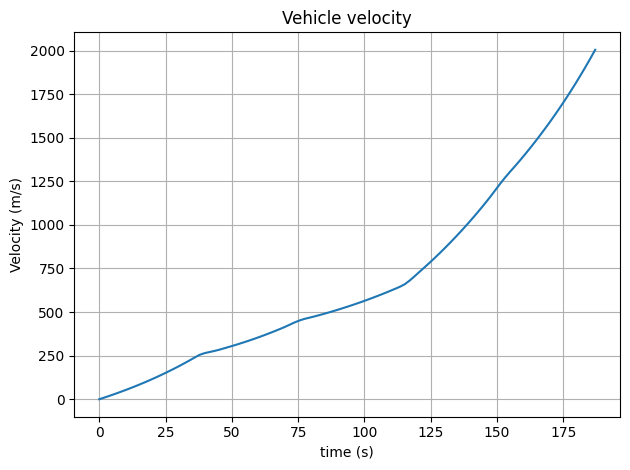

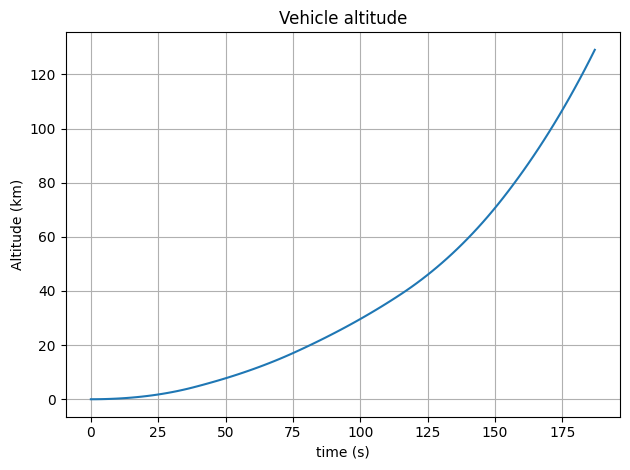

In [ ]:
#
# 6.  RE-INTEGRATE WITH THE WINNING SCHEDULES AND MAKE THE PLOTS
#

def plot_thrust_and_prop(best_core, best_boost):
    # 1) build throttle functions for the optimum
    thr_core  = make_throttle_fn(best_core)
    thr_boost = make_throttle_fn(best_boost)

    # 2) re-integrate the ascent (first stage only) with dense output
    deriv = partial(derivatives, thr_core=thr_core, thr_boost=thr_boost)
    sol   = solve_ivp(deriv,
                      t_span=[0, CORE['burn']],
                      y0=S0,
                      max_step=11.0,          # fine enough for plots
                      dense_output=True)

    # 3) sample on a uniform grid
    t_plot = np.linspace(sol.t[0],     # first element of the vector
                     sol.t[-1],    # last element of the vector
                     100)
    x, v, mB, mC, _ = sol.sol(t_plot)

    # 4) instantaneous throttles and thrusts
    def thrust_booster(t):
        p = pressure_ussa(sol.sol(t)[0])
        return thr_boost(t) * thrust_interp(BOOSTER, p) if t <= BOOSTER['burn'] else 0.0

    def thrust_core_f(t):
        p = pressure_ussa(sol.sol(t)[0])
        return thr_core(t) * thrust_interp(CORE, p) if t <= CORE['burn'] else 0.0

    Tb_vec = np.vectorize(thrust_booster)(t_plot)
    Tc_vec = np.vectorize(thrust_core_f)(t_plot)
    T_tot  = Tb_vec + Tc_vec

    # 5) cumulative propellant usage (kg)
    prop_used = (BOOSTER['m_prop'] - mB) + (CORE['m_prop'] - mC)

    # PLOTS
    # (a) Thrust profile
    plt.figure()
    plt.plot(t_plot, T_tot/1e6, label='total', lw=2)
    plt.plot(t_plot, Tc_vec/1e6, '--', label='core')
    plt.plot(t_plot, Tb_vec/1e6, ':', label='boosters')
    plt.xlabel('time (s)')
    plt.ylabel('thrust (MN)')
    plt.title('Thrust Profile (first stage)')
    plt.legend();  plt.grid(True);  plt.tight_layout()

    # (b) Propellant utilisation
    plt.figure()
    plt.plot(t_plot, prop_used/1e3)
    plt.xlabel('time (s)')
    plt.ylabel('propellant used (tonnes)')
    plt.title('Cumulative propellant mass burned')
    plt.grid(True);  plt.tight_layout()
    plt.show()

    # (c) Vehicle velocity
    plt.figure()
    plt.plot(t_plot, v)
    plt.xlabel('time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Vehicle velocity')
    plt.grid(True);  plt.tight_layout()
    plt.show()

    # (d) Vehicle altitude
    plt.figure()
    plt.plot(t_plot, x/1e3)
    plt.xlabel('time (s)')
    plt.ylabel('Altitude (km)')
    plt.title('Vehicle altitude')
    plt.grid(True);  plt.tight_layout()
    plt.show()
#
# 7.  MAIN
#
if __name__ == "__main__":
    best_core, best_boost = run_optimization()
    plot_thrust_and_prop(best_core, best_boost)
